# Welcome to our Group Project - Milestone 2 Notebook

### Step 0: Environment Setup

In [1]:
import os, pickle, glob
import pyspark
from pyspark.sql import SparkSession

In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "3g") \
    .config('spark.executor.instances', 19) \
    .getOrCreate()

### Step 1: Load the dataset - PLEASE SKIP TO STEP 2!

This section leverages python's gdown library to take in files from Google Drive and upload them into this environment. The files were originally downloaded from huggingface at this link: https://huggingface.co/datasets/BIOMEDICA/biomedica_webdataset_24M/tree/main/noncommercial

The reason for using Google Drive instead of downloading directly from huggingface is because the BIOMEDICA dataset requires sign in and submission of an authorization request before one can access the files, which would complicate API use if another user tried accessing this project file. Instead, downloading the files from huggingface and then uploading them to Google Drive with the sharing setting "anyone with the link can access" makes the files more easily accessible.

With that being said, the data has been loaded, unpacked, and compressed into a parquet file. In order to conserve our computing resources, please DO NOT run the code in this section. You can safely skip ahead to Step 2, where the code will take you through loading the dataset from parquet, which will be faster and less resource-intensive.

In [5]:
#%pip install gdown

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown

# This is taking in the google drive file ID for each BIOMEDICA file we want to upload
files = [
    "1GxPYAxUYIhg7h5-9H8NRxOt7Fx0Xx9Zk", # file 000000
    "1XT7jK1YC4T8ElBIemY1BEQPT2LLv70jS", # file 000001
    "1yYMVnCbHzgeVylJZSJ9OdiP4nn2ih4Fv", # file 000002
    "1UD6xTY1xKI8hH1XCEuUPsGC0BFfzDeZr", # file 000003
    "1DxYtwxzMiRAMu8oOqh144upKbOaZBCxi", # file 000004
    "1PxH5jQBoX6QLLml6nRm3-E7fUcYXGAlD", # file 000005
    "1WFRXCWwqe0lCSoHBpBX_7aDM_PPKe_EX", # file 000006
    "14c1hxrR__VEh-xU18lBFRp0MbY1afLak", # file 000007
    "1NUdZXFNbwQP2GEHbjyhGgEn6tk5n0_HT", # file 000008
    "1ctGtFZdxclqr0UHJyc0KuWWisyB-KL15", # file 000009
    "1StBDH91SFSBF2sQS-ulv6051uoKwXv9M", # file 000010
]

for fid in files:
    gdown.download(f"https://drive.google.com/uc?id={fid}", quiet = False)

ModuleNotFoundError: No module named 'gdown'

Now we need to get the image data properly formatted in a Spark RDD

In [6]:
import os
import tarfile

# Create a directory to extract to
extract_dir = "extracted_images"
os.makedirs(extract_dir, exist_ok = True)

# Extract all .tar files in the current directory
for fname in os.listdir():
    if fname.endswith(".tar"):
        with tarfile.open(fname) as tar:
            tar.extractall(path = extract_dir)

I had to make a new spark session to continue unpacking and saving because I ran out of time halfway through the process, so this was a check to make sure the files were still available before continuing

In [5]:
import os

# Check if folder exists
print("Folder exists:", os.path.exists("extracted_images"))

# See how many files are inside
file_count = sum(len(files) for _, _, files in os.walk("extracted_images"))
print("Number of files inside:", file_count)

Folder exists: True
Number of files inside: 330000


In [ ]:
# sbatch read json individually
# spark.read.json
# try with only 1 .tar file, 1000 .json per
# feed that directory into read_json
# then try 1 .tar, then scale to all

In [7]:
import os

extract_dir = "extracted_images"
# Get the list of files in the directory
files = os.listdir(extract_dir)

# Print the first file name
if files:
    print(files[0])

filelist_noncommercial_batch_121_13-PMC9621019-2-NSS-14-1927-g0004.json


Check extracted_images

In [61]:
extensions = set()
for root, dirs, files in os.walk('extracted_images'):
    for file in files:
        _, ext = os.path.splitext(file)
        extensions.add(ext.lower())  # Get file extension in lowercase

print("File extensions in the directory:", extensions)

File extensions in the directory: {'.json', '.jpg', '.txt'}


We need to handle each file type separately

In [63]:
# List of JSON files (sorted)
json_files = sorted(glob.glob("extracted_images/*.json"))

# Load JSON files into a DataFrame
json_df = sc.read.json(json_files)

In [3]:
# Show the DataFrame schema to check the loaded data - warning this is VERY long
# json_df.printSchema()

In [65]:
# Show a preview of the data
json_df.show()

+--------------------+--------------------+--------------------+------------+--------------------+--------------------+---------------+--------------------+-----------------------+---------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------------+----------------+-------------------+---------------------+--------------------+----------+
|    article_abstract|article_accession_id|    article_citation|article_date|     article_journal|    article_keywords|article_license|  article_mesh_terms|article_reference_count|article_reference_ids|article_reference_list|     article_subject|        article_text|       article_title|    image_cluster_id|       image_context|     image_file_name|          image_hash|image_label_id|image_panel_subtype|image_panel_type|image_primary_label|image_secondary_label|           image_set|image_size|
+-

In [68]:
# Now for the .txt files
txt_files = sorted(glob.glob("extracted_images/*.txt"))
txt_path_str = ",".join(txt_files)
txt_rdd = sc.sparkContext.textFile(txt_path_str)

In [69]:
# Preview text files
txt_rdd.take(5)

['Actin and myosin IIA interaction with WIP is independent of WASp. YTS/KIR2DL1 cells were transfected with FLAG-WIP or FLAG-WIPΔ460-503, which is a mutant protein lacking the WASp binding domain. Transfected cells were mixed with 721.221 cells and incubated for the indicated times at 37°C. Cell lysates were immunoprecipitated with anti-FLAG mAb. Immunoprecipitated proteins were immunoblotted with anti–myosin IIA, anti-FLAG, anti-WASp, or anti-actin antibodies. The molecular masses of the proteins according to their position relative to molecular mass markers are shown in parentheses. The absence of WASp does not affect recruitment of either actin or myosin IIA to the complex.',
 'Syt IV interacts with Stx6. (A) Cell lysates from HEK cells transfected with myc-Stx6 were incubated with GST-Syt IV CD or GST bound to glutathione beads. (B) PC12 cells were lysed in TNTE buffer and incubated with 5 or 10 μg of anti-Stx6 antibody overnight at 4°C, and subsequently bound to protein G beads. I

In [72]:
# And finally the image data
jpg_files = sorted(glob.glob("extracted_images/*.jpg"))
jpg_path_str = ",".join(jpg_files)
jpg_rdd = sc.sparkContext.binaryFiles(jpg_path_str)

In [73]:
# Preview one
jpg_rdd.take(1)

[('file:/expanse/lustre/projects/uci150/ntorno/group_project/extracted_images/filelist_noncommercial_batch_0_10-PMC2063796-5-jcb1730121f05.jpg',
  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8b\x01\x90\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x

Great! Now we can convert these into dataframes for parquet writing

In [ ]:
# TXT
txt_df = sc.createDataFrame(txt_rdd.map(lambda x: (x,)), ["text"])

# JPG
jpg_df = sc.createDataFrame(jpg_rdd.map(lambda x: (x[0], len(x[1]))), ["file_path", "file_size"])

Write parquet files

In [78]:
json_df.write.parquet("parquet_datasets/json_data")

In [79]:
txt_df.write.parquet("parquet_datasets/text_data")

In [80]:
jpg_df.write.parquet("parquet_datasets/image_data")

Redo jpg for formatting

In [19]:
from pyspark.ml.image import ImageSchema

# Load the images as a DataFrame
image_df = sc.read.format("image").load("extracted_images/*.jpg")

In [20]:
# Check the schema of the loaded image DataFrame
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
from PIL import Image
import io
from PIL import UnidentifiedImageError

# Define a UDF to resize the image
def resize_image(image_data, target_width=224, target_height=224):
    try:
        img = Image.open(io.BytesIO(image_data))
        img = img.resize((target_width, target_height))
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='JPEG')
        return img_byte_arr.getvalue()
    except UnidentifiedImageError:
        # Handle invalid image data, e.g., return None or log the error
        return None

# Register the UDF
resize_image = udf(resize_image, BinaryType())

# Apply the UDF to the image DataFrame
resized_df = image_df.withColumn("image_data_resized", resize_image(image_df["image.data"]))

In [22]:
# Show the resized DataFrame schema
resized_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_data_resized: binary (nullable = true)



In [23]:
# Preview the resized images
resized_df.select("image.origin", "image.height", "image.width").show(5)

+--------------------+------+-----+
|              origin|height|width|
+--------------------+------+-----+
|file:///expanse/l...|  1920| 1571|
|file:///expanse/l...|  1800|  714|
|file:///expanse/l...|  1080|  810|
|file:///expanse/l...|  2961|  747|
|file:///expanse/l...|  1200|  791|
+--------------------+------+-----+
only showing top 5 rows



In [24]:
# Update the height and width for the resized images
target_width = 224
target_height = 224

from pyspark.sql.functions import lit

resized_df_with_dimensions = resized_df.withColumn("image.height", lit(target_height)) \
                                        .withColumn("image.width", lit(target_width))

In [25]:
from pyspark.sql.functions import struct, lit

# Create a new "image" struct with updated height and width
resized_df_with_dimensions = resized_df.withColumn(
    "image", 
    struct(
        "image.origin",
        lit(target_height).alias("height"),
        lit(target_width).alias("width"),
        "image.nChannels",
        "image.mode",
        "image.data"
    )
)

In [26]:
# Show the updated schema with resized dimensions
resized_df_with_dimensions.printSchema()

root
 |-- image: struct (nullable = false)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_data_resized: binary (nullable = true)



In [27]:
# Preview the updated DataFrame
resized_df_with_dimensions.select("image.origin", "image.height", "image.width").show(5)

+--------------------+------+-----+
|              origin|height|width|
+--------------------+------+-----+
|file:///expanse/l...|   224|  224|
|file:///expanse/l...|   224|  224|
|file:///expanse/l...|   224|  224|
|file:///expanse/l...|   224|  224|
|file:///expanse/l...|   224|  224|
+--------------------+------+-----+
only showing top 5 rows



In [28]:
# Try writing just a few records to test the pipeline
resized_df_with_dimensions.limit(10).write.mode("overwrite").parquet("parquet_datasets/test_image_data")

In [30]:
# Now try reading in that file
test_df = sc.read.parquet("parquet_datasets/test_image_data")

In [31]:
# Check schema
test_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_data_resized: binary (nullable = true)



In [33]:
# Show the content of the test file to confirm
test_df.select("image").show(10)

+--------------------+
|               image|
+--------------------+
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
|{file:///expanse/...|
+--------------------+



In [34]:
# Ok, that did not work either
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType
from PIL import Image
import io

# Define UDF to open, resize, and return image bytes
def resize_image_udf(image_path):
    try:
        # Open the image file
        with Image.open(image_path.replace("file://", "")) as img:
            img = img.convert("RGB")
            img = img.resize((224, 224))
            buffer = io.BytesIO()
            img.save(buffer, format = "JPEG")
            return buffer.getvalue()
    except Exception as e:
        return None

resize_udf = udf(resize_image_udf, BinaryType())

# Apply UDF
resized_df_with_dimensions = image_df.withColumn("image_data_resized", resize_udf("image.origin"))

In [35]:
# Write again
resized_df_with_dimensions.write.mode("overwrite").parquet("parquet_datasets/test_image_data2")

In [37]:
# Read again
test_df = sc.read.parquet("parquet_datasets/test_image_data2")
test_df.select("image_data_resized").show(5)

+--------------------+
|  image_data_resized|
+--------------------+
|[FF D8 FF E0 00 1...|
|[FF D8 FF E0 00 1...|
|[FF D8 FF E0 00 1...|
|[FF D8 FF E0 00 1...|
|[FF D8 FF E0 00 1...|
+--------------------+
only showing top 5 rows



In [48]:
# That worked! Now we can use the image data effectively

### Step 2: Load dataset and begin investigating

Beginning with text data

In [4]:
# Read the text data Parquet file into a DataFrame
txt_df = sc.read.parquet("parquet_datasets/text_data")

In [5]:
# Check schema
txt_df.printSchema()

root
 |-- text: string (nullable = true)



In [6]:
# Check how many entries there are
num_entries = txt_df.count()
print(f"Number of entries: {num_entries}")

Number of entries: 1113


In [7]:
# Check for null values
from pyspark.sql import functions as F

txt_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in txt_df.columns]).show()

+----+
|text|
+----+
|   0|
+----+



Now json data

In [8]:
# Read the JSON data Parquet file into a DataFrame
json_df = sc.read.parquet("parquet_datasets/json_data")

In [9]:
# Check schema - warning if you run this the output is VERY long
# json_df.printSchema()

In [10]:
# Check how many entries we have
num_entries = json_df.count()
print(f"Number of entries: {num_entries}")

Number of entries: 897


In [11]:
json_df.show(1)

+--------------------+--------------------+--------------------+------------+-------------------+--------------------+---------------+--------------------+-----------------------+---------------------+----------------------+-------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------+-------------------+----------------+-------------------+---------------------+--------------------+----------+
|    article_abstract|article_accession_id|    article_citation|article_date|    article_journal|    article_keywords|article_license|  article_mesh_terms|article_reference_count|article_reference_ids|article_reference_list|    article_subject|        article_text|       article_title|image_cluster_id|       image_context|     image_file_name|          image_hash|image_label_id|image_panel_subtype|image_panel_type|image_primary_label|image_secondary_label|           image_set|image_size|
+-------------

In [12]:
# Check what columns we have - this version is easier to read than the printSchema output
print(json_df.columns)

['article_abstract', 'article_accession_id', 'article_citation', 'article_date', 'article_journal', 'article_keywords', 'article_license', 'article_mesh_terms', 'article_reference_count', 'article_reference_ids', 'article_reference_list', 'article_subject', 'article_text', 'article_title', 'image_cluster_id', 'image_context', 'image_file_name', 'image_hash', 'image_label_id', 'image_panel_subtype', 'image_panel_type', 'image_primary_label', 'image_secondary_label', 'image_set', 'image_size']


In [13]:
# Find number of unique aritcle titles
unique_titles_count = json_df.select("article_title").distinct().count()
print(f"Number of unique article titles: {unique_titles_count}")

Number of unique article titles: 833


In [15]:
# View distinct article titles
unique_titles_df = json_df.select('article_title').distinct()

unique_titles_df.show(10)

+--------------------+
|       article_title|
+--------------------+
|Differential meta...|
|Dynein light chai...|
|Upregulation of S...|
|Application of a ...|
|Polymeric implant...|
|Cytochrome P450 e...|
|Escherichia coli ...|
|Mrd1p binds to pr...|
|{'@toggle': 'yes'...|
|Synthesis, Charac...|
+--------------------+
only showing top 10 rows



In [14]:
# Find number of unique image primary labels
unique_image_primary_labels = json_df.select("image_primary_label").distinct().count()
print(f"Number of unique image primary labels: {unique_image_primary_labels}")

Number of unique image primary labels: 1


In [16]:
# View the primary image label
unique_image_primary = json_df.select("image_primary_label").distinct()

unique_image_primary.show()

+-------------------+
|image_primary_label|
+-------------------+
|    [Immuno Assays]|
+-------------------+



In [17]:
# Find number of unique image secondary labels
unique_image_secondary_labels = json_df.select("image_secondary_label").distinct().count()
print(f"Number of unique image secondary labels: {unique_image_secondary_labels}")

Number of unique image secondary labels: 1


In [18]:
# View the primary image label
unique_image_secondary = json_df.select("image_secondary_label").distinct()

unique_image_secondary.show()

+---------------------+
|image_secondary_label|
+---------------------+
|         [immunoblot]|
+---------------------+



And finally the image data

In [38]:
# Read the image data Parquet file into a DataFrame
image_df = sc.read.parquet("parquet_datasets/test_image_data2")
image_df.show(5)

+--------------------+--------------------+
|               image|  image_data_resized|
+--------------------+--------------------+
|{file:///expanse/...|[FF D8 FF E0 00 1...|
|{file:///expanse/...|[FF D8 FF E0 00 1...|
|{file:///expanse/...|[FF D8 FF E0 00 1...|
|{file:///expanse/...|[FF D8 FF E0 00 1...|
|{file:///expanse/...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+
only showing top 5 rows



In [39]:
# Check total number of images
print("Total images:", image_df.count())

Total images: 898


In [40]:
# Show the DataFrame schema to understand the structure
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_data_resized: binary (nullable = true)



In [41]:
# Inspect image data
image_df.select("image.origin", "image.height", "image.width").show(5)

+--------------------+------+-----+
|              origin|height|width|
+--------------------+------+-----+
|file:///expanse/l...|  1920| 1571|
|file:///expanse/l...|  1800|  714|
|file:///expanse/l...|  1080|  810|
|file:///expanse/l...|  2961|  747|
|file:///expanse/l...|  1200|  791|
+--------------------+------+-----+
only showing top 5 rows



In [42]:
# Decode image data
from PIL import Image
import io
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

# Define a function to check if image data is valid
def try_decode_image(content):
    try:
        image = Image.open(io.BytesIO(content))
        image.verify()  # Verify image integrity
        return True
    except:
        return False

# Register the function as a UDF
is_valid_image_udf = udf(try_decode_image, BooleanType())

In [43]:
# Apply UDF to check validity of each image in image_data_resized column
image_df = image_df.withColumn("is_valid", is_valid_image_udf("image_data_resized"))

# Optional: Show some results
image_df.select("image.origin", "is_valid").show(5)

+--------------------+--------+
|              origin|is_valid|
+--------------------+--------+
|file:///expanse/l...|    true|
|file:///expanse/l...|    true|
|file:///expanse/l...|    true|
|file:///expanse/l...|    true|
|file:///expanse/l...|    true|
+--------------------+--------+
only showing top 5 rows



In [44]:
# Count valid and invalid images
valid_count = image_df.filter(F.col("is_valid") == True).count()
invalid_count = image_df.filter(F.col("is_valid") == False).count()

print(f"Valid images: {valid_count}")
print(f"Corrupt or unreadable images: {invalid_count}")

Valid images: 898
Corrupt or unreadable images: 0


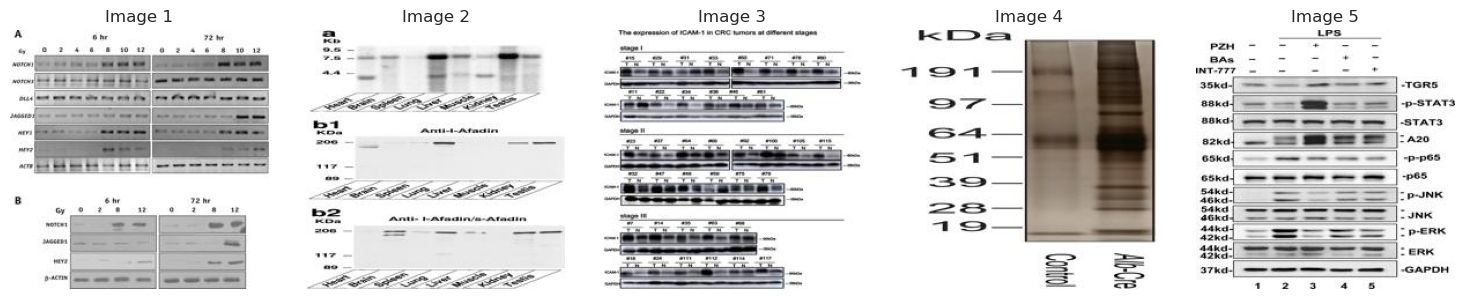

In [47]:
# Make a few graphs to visualize the images
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import io

sns.set(style="whitegrid")

# Decode first 5 valid images
sample_images = image_df.select("image.origin", "image_data_resized").limit(5).collect()

# Plot them
plt.figure(figsize=(15, 3))
for i, row in enumerate(sample_images):
    # Decode the image data
    img_data = row["image_data_resized"]
    img = Image.open(io.BytesIO(img_data))
    
    # Convert to numpy array for plotting
    img_array = np.array(img)

    # Plot the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image {i + 1}")

# Show the plots
plt.tight_layout()
plt.show()

### Step 3: Dimensionality Reduction via NMF

Non-negative Matrix Factorization (NMF) is an alternative to Principal Component Analysis (PCA) which can often handle variation in image data more effectively. This is because PCA achieves dimensionality reduction by finding averages, whereas NMF finds modes in the dataset to explain variance instead, which tends to be a more accurate method for capturing natural variation across images. Unfortunately, pyspark ML does not have its own NMF function, and using pandas dataframes with scikit-learn will likely not be possible with a dataset this size. Instead, the below code walks through functions to define and run NMF in pyspark.

In [ ]:
# NMF Step 1 - convert image_rdd to matrix representation
from pyspark.sql import Row
import numpy as np

def convert_to_matrix(row):
    return np.array(row[1]) 

matrix_data = image_rdd.map(convert_to_matrix)

In [ ]:
# NMF Step 2 - initialization of W and H factors for NMF calculations
num_samples = len(matrix_data.collect())
num_features = 10  # Set the number of features for factorization
num_iterations = 50

# Initialize W and H randomly with positive values
# These values will be updated based on our dataset in the next step
W = np.random.rand(num_samples, num_features)
H = np.random.rand(num_features, num_samples)

# Convert W and H into RDDs
W_rdd = sc.parallelize(W.tolist())
H_rdd = sc.parallelize(H.tolist())

In [ ]:
# NMF Step 3 - iterative optimization of W and H
def nmf_iteration(W_rdd, H_rdd, matrix_data, num_features):
    # Update W
    new_W = W_rdd.map(lambda w_row: update_W(w_row, H_rdd, matrix_data, num_features))
    
    # Update H
    new_H = H_rdd.map(lambda h_col: update_H(h_col, W_rdd, matrix_data, num_features))
    
    return new_W, new_H

import numpy as np

epsilon = 1e-8

def update_W(matrix_data_rdd, W_rdd, H):
    HT = H.T
    HHT = H @ HT
    broadcast_H = sc.broadcast(H)
    broadcast_HHT = sc.broadcast(HHT)
    return matrix_data_rdd.join(W_rdd).mapValues(
        lambda v_w: v_w[1] * ((v_w[0] @ broadcast_H.value.T) / 
                              (v_w[1] @ broadcast_HHT.value + epsilon))
    )

def update_H(matrix_data_rdd, W_rdd, H):
    WT = W_rdd.map(lambda x: x[1]).collect()
    WT = np.array(WT).T  
    V = np.array(matrix_data_rdd.map(lambda x: x[1]).collect()).T 
    WT_V = WT @ V
    WT_W = WT @ WT.T
    return H * (WT_V / (WT_W @ H + epsilon))

In [ ]:
# NMF Step 4 - collect results
W_final = W_rdd.collect()
H_final = H_rdd.collect()

# Convert to a more usable form 
W_final_matrix = np.array(W_final)
H_final_matrix = np.array(H_final)

In [ ]:
# NMF Step 5 - examine cluster distribution

V_reconstructed = np.dot(W_final_matrix, H_final_matrix)

# Cluster NMF output
from sklearn.cluster import KMeans
num_clusters = 5

kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
cluster_labels = kmeans.fit_predict(W_final_matrix)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot how many images fall into each cluster
sns.countplot(x = cluster_labels)
plt.title("Distribution of Images Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [ ]:
# NMF Step 6 - print sample images for each cluster

sample_images = decoded_rdd.collect()

for cluster_id in range(num_clusters):
    indices = np.where(cluster_labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: showing 5 sample images")
    plt.figure(figsize = (15, 3))
    for i, idx in enumerate(indices[:5]):
        path, img = sample_images[idx]
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{path.split('/')[-1]}")
    plt.show()